# NSF Computer and Information Science and Engineering (CISE) 

- `0505****`: Division of Computer and Network Systems (CNS)
- `0501****`: Division of Computing and Communication Foundations (CCF)
- `0502****`: Division of Information and Intelligent Systems (IIS)
- `0509****`: Office of Advanced Cyberinfrastructure (OAC)

In [33]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [34]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "0505": "Division of Computer and Network Systems (CNS)",
    "0501": "Division of Computing and Communication Foundations (CCF)",
    "0502": "Division of Information and Intelligent Systems (IIS)",
    "0509": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [35]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"][:4] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [36]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 413
Division of Computing and Communication Foundations (CCF) 349
Division of Information and Intelligent Systems (IIS) 365
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 653, 2: 246, 3: 125, 5: 84, 4: 63, 6: 4, 0: 2, 7: 2, 8: 1})


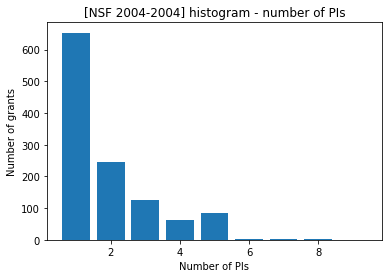

In [37]:
histogram_num_pis(data, years, div_type.keys())

In [38]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0401049', '0403020', '0403130', '0403590', '0404001', '0404011', '0404193', '0404297', '0404440', '0406305', '0406345', '0406384', '0410203', '0410246', '0410409', '0410524', '0410553', '0410771', '0410790', '0410918', '0410937', '0411127', '0411152', '0411307', '0412029', '0412858', '0412884', '0412894', '0412930', '0412965', '0413012', '0413078', '0413085', '0413138', '0413196', '0413214', '0413227', '0413251', '0413284', '0413321', '0413328', '0413709', '0414380', '0414409', '0414482', '0414557', '0414567', '0414630', '0414710', '0414762', '0414763', '0414791', '0414815', '0414976', '0414981', '0415016', '0415021', '0415101', '0415175', '0415195', '0415257', '0415865', '0415923', '0416364', '0417607', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423039', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426557', '0426627', '0426674', '0426879', '0426904', '0427260', '0427385', '0427695', '0428427'

In [39]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

246 grants with 2 PIs


In [40]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0404297 union=2, max_group=2, numpub=3 6 5
0410203 union=2, max_group=2, numpub=6 6 1
0410246 union=2, max_group=2, numpub=13 16 4
0410409 union=1, max_group=1, numpub=2 2 0
0410553 union=2, max_group=2, numpub=7 8 3
0410771 union=2, max_group=2, numpub=9 15 9
0410918 union=2, max_group=2, numpub=8 18 12
0410937 union=2, max_group=2, numpub=19 40 27
0411127 union=2, max_group=2, numpub=1 41 41
0411152 union=0, max_group=0, numpub=1 1 0
0411307 union=2, max_group=2, numpub=6 33 29
0412029 union=1, max_group=1, numpub=1 1 0
0412884 union=1, max_group=1, numpub=8 8 0
0412894 union=1, max_group=1, numpub=7 7 0
0412930 union=2, max_group=2, numpub=12 12 1
0413012 union=2, max_group=2, numpub=2 5 4
0413078 union=1, max_group=1, numpub=3 3 0
0413085 union=2, max_group=2, numpub=4 16 15
0413138 union=2, max_group=2, numpub=10 10 1
0413196 union=1, max_group=1, numpub=23 23 0
0413214 union=2, max_group=1, numpub=16 16 0
0413227 union=2, max_group=2, numpub=4 13 12
0413251 union=2, max_group=2, 

In [41]:
collab_type = {}
dict_period = {}
dict_amount = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        coauthor = set()
        for e in G_all.edges.data():
            if e[2]["paper"] == data["paper"]:
                coauthor.update([e[0], e[1]])
        num_coauthor = len(coauthor)
#         print(data["paper"], num_coauthor)
        print(grant_id, data["paper"], num_coauthor)
        
#         print(data["paper"], num_coauthor)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])

print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

0404297 2599364901 5
0404297 1548079979 5
0404297 1993760683 5
0404297 188386583 5
0404297 2098491294 5
0410203 2507902825 3
0410246 80472130 3
0410246 2040308490 4
0410246 2150315571 3
0410246 2327590935 4
0410553 2166402976 3
0410553 2154209908 3
0410553 2117040175 3
0410771 1988124224 3
0410771 1591040101 4
0410771 2134940363 2
0410771 2098811885 4
0410771 2133448173 4
0410771 1959073722 4
0410771 2143636443 4
0410771 2059065724 3
0410771 2103052126 3
0410918 2013854854 3
0410918 2161903763 3
0410918 2188508564 4
0410918 2102039064 3
0410918 105131483 4
0410918 137017884 3
0410918 2189618275 3
0410918 2172023269 3
0410918 2103816232 5
0410918 1551162551 3
0410918 2106244281 3
0410918 175055547 4
0410937 2098540801 4
0410937 2114331787 3
0410937 2013863826 4
0410937 2891254164 3
0410937 2024945307 7
0410937 2091483166 3
0410937 2144416297 4
0410937 2038101290 3
0410937 2168014130 11
0410937 2147481669 5
0410937 2113924808 7
0410937 2010890189 5
0410937 2044062670 4
0410937 74208207 5

0428427 1499623512 2
0428427 1546207031 3
0429154 2086112425 3
0429154 2555121777 4
0429154 2090561681 4
0429154 2148855255 4
0429154 2152203581 3
0429154 2115143695 4
0429228 2168058952 4
0429228 267918989 3
0429228 2545815118 2
0429228 2164580880 2
0429228 2044657527 4
0429228 2129010335 4
0429364 2119985794 9
0429364 2188800392 4
0429364 1574648717 4
0429364 1856971918 7
0429364 2107903248 4
0429364 2136209041 7
0429364 1986648850 7
0429364 1964402839 3
0429364 1582991129 11
0429364 2612341273 3
0429364 2084334238 6
0429364 1586272167 11
0429364 2102766632 3
0429364 1556578092 7
0429364 2584247852 11
0429364 1566166064 5
0429364 1741087670 8
0429364 2144588087 10
0429364 1498464828 8
0429364 1978879806 3
0429364 2549822271 5
0429364 2372592707 3
0429364 1566363079 4
0429364 55875535 7
0429364 1760892502 10
0429364 2056797271 9
0429364 1523665759 11
0429364 2613541219 4
0429364 1731154916 3
0429364 1989377254 5
0429364 2152725350 3
0429364 2066636904 4
0429364 1586510703 4
0429364 18

0430510 2106447363 3
0430510 147895047 4
0430510 1910816777 7
0430510 2069984009 5
0430510 2086838666 7
0430510 2168674192 5
0430510 1508521621 7
0430510 2099323800 6
0430510 1585471902 5
0430510 2004484769 4
0430510 2147740195 4
0430510 1620900388 5
0430510 1569757987 5
0430510 1577165222 5
0430510 2293878697 7
0430510 2274235828 3
0430510 2126789306 5
0430510 1770174463 5
0430510 2128352062 7
0430510 1698117324 5
0430510 2068983118 6
0430510 2038345682 5
0430510 1850597240 6
0430510 2022582229 5
0430510 1487382749 3
0430510 2294423262 6
0430510 2125264097 4
0430510 1985727586 4
0430510 2154753892 4
0430510 115127268 6
0430510 1726660068 3
0430510 138229359 4
0430510 186249712 7
0430510 2139359217 5
0430510 118129268 4
0430510 1540902136 3
0430510 1966383354 5
0430510 1827755647 5
0430781 1975303279 6
0430781 2089732905 10
0430781 2040933249 4
0430781 1995297249 12
0430849 2154937603 4
0430849 2017619076 5
0430849 2584609412 7
0430849 2121573131 3
0430849 2105401484 7
0430849 85097294

0435111 88752697 4
0435111 2104398282 3
0435111 2135289087 4
0435247 1991357351 3
0435247 2037415870 3
0435247 2048855920 4
0435247 2123492772 5
0435272 1505301880 5
0435272 2171496711 3
0435272 2079156232 3
0435272 1978826249 3
0435272 2755577992 9
0435272 1496706313 4
0435272 2102589200 11
0435272 1885778852 4
0435272 2012253736 3
0435272 2060311081 6
0435272 2519068331 3
0435272 2142646704 3
0435272 2044183862 5
0435272 2346843068 3
0435272 2284876990 3
0435272 6147067 4
0435272 2005291211 3
0435272 1763716939 4
0435272 2203221455 2
0435272 2151861976 3
0435272 2112326623 3
0435272 47395808 3
0435272 2008904160 3
0435272 2187965929 4
0435272 99947114 5
0435272 2096254570 3
0435272 2107836909 5
0435272 2132405999 2
0435272 2301719024 3
0435272 1895806193 3
0435272 2292379254 3
0435272 1905794424 3
0435272 2064525435 3
0435272 1968323964 3
0435272 1880209405 7
0435272 2141760382 3
0435303 2143756451 3
0435303 2105413189 4
0435303 1710235590 3
0435303 2089770759 3
0435303 2158794280 3


In [42]:
for grant_id in two_separate:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in two_separate:
    collab_type[gid] = "two_separate" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 160, '111': 37, '010': 20, '110': 16, 'two_separate': 15, '011': 13})


In [43]:
for grant_id in only_one_pi:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in only_one_pi:
    collab_type[gid] = "only_one_pi" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 160, 'only_one_pi': 42, '111': 37, '010': 20, '110': 16, 'two_separate': 15, '011': 13})


In [44]:
set([k for k in dict_timestamps.keys() if collab_type[k] not in ["000", "only_one_pi", "two_separate"]])-set(two_cowork)

{'0429631'}

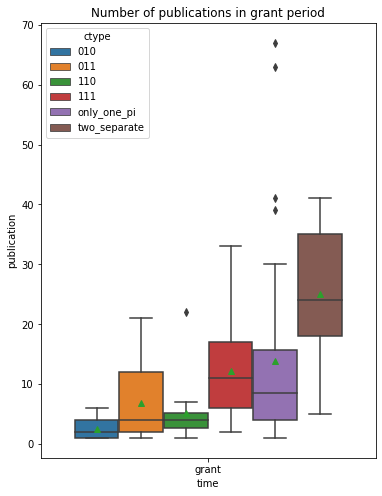

In [45]:
x = ["grant"]
ctype = ["010", "011", "110", "111", "only_one_pi", "two_separate"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_amount": [dict_amount[k] for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

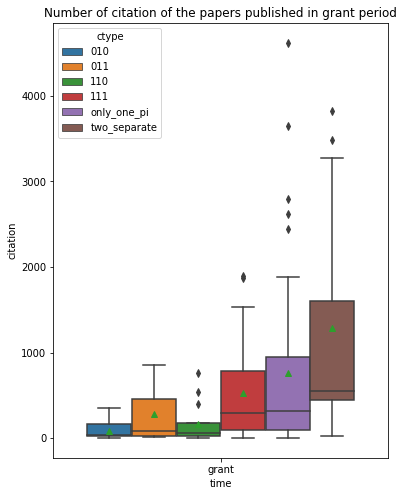

In [46]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

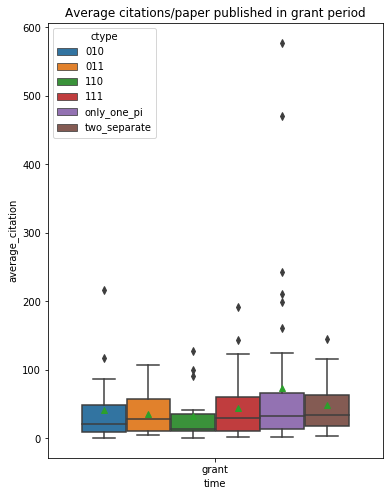

In [47]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

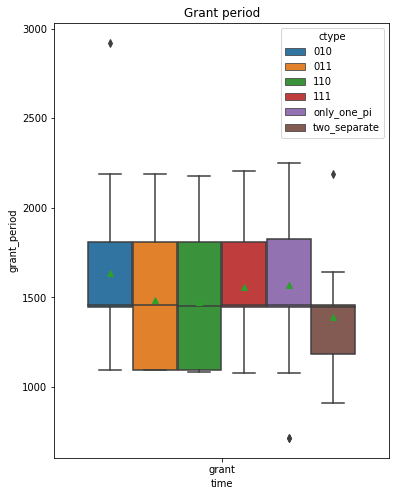

In [48]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

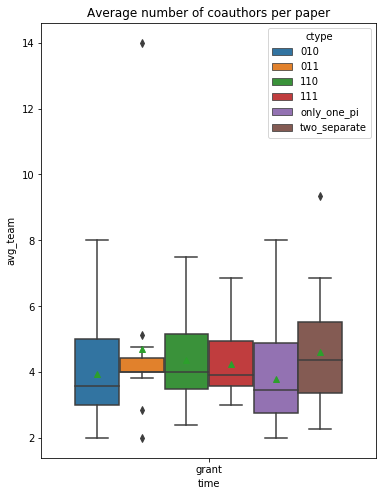

In [49]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")

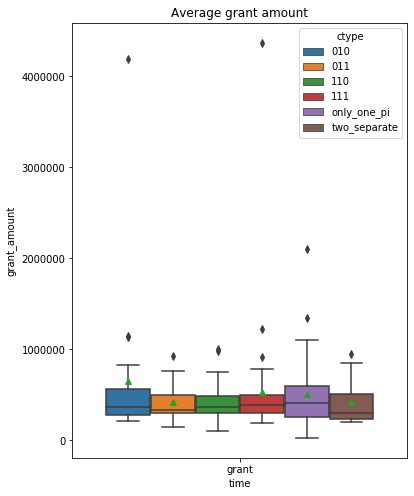

In [50]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_amount", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average grant amount")

In [51]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


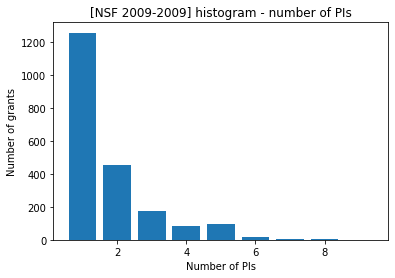

In [52]:
histogram_num_pis(data, years, div_type.keys())

In [53]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs


In [54]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) >= 2 and pi_max_group >= 2:
        two_cowork.append(pid)
    elif len(pi_union) >= 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0902885 union=1, max_group=1, numpub=4 4 0
0903191 union=2, max_group=2, numpub=9 28 22
0903430 union=2, max_group=2, numpub=8 10 5
0903432 union=3, max_group=2, numpub=25 67 44
0903437 union=2, max_group=2, numpub=1 96 96
0903447 union=2, max_group=2, numpub=2 6 5
0903549 union=2, max_group=1, numpub=6 6 0
0904116 union=2, max_group=1, numpub=4 4 0
0904338 union=1, max_group=1, numpub=14 14 0
0904353 union=3, max_group=2, numpub=12 20 9
0904431 union=2, max_group=2, numpub=1 17 17
0904449 union=2, max_group=2, numpub=6 13 8
0904482 union=2, max_group=2, numpub=5 39 39
0904501 union=2, max_group=1, numpub=14 14 0
0904549 union=1, max_group=1, numpub=1 1 0
0904572 union=2, max_group=2, numpub=6 25 21
0904597 union=2, max_group=1, numpub=19 19 0
0904625 union=2, max_group=2, numpub=10 17 12
0904631 union=2, max_group=1, numpub=47 47 0
0904672 union=1, max_group=1, numpub=3 3 0
0904684 union=1, max_group=1, numpub=2 2 0
0904729 union=2, max_group=2, numpub=7 17 15
0904754 union=1, max_gro

0917238 union=1, max_group=1, numpub=5 5 0
0917251 union=2, max_group=2, numpub=6 22 18
0917257 union=1, max_group=1, numpub=4 4 0
0917261 union=2, max_group=2, numpub=3 66 64
0917265 union=2, max_group=2, numpub=7 32 29
0917274 union=2, max_group=2, numpub=29 74 67
0917288 union=2, max_group=2, numpub=20 50 33
0917315 union=2, max_group=2, numpub=1 9 9
0917340 union=2, max_group=2, numpub=1 1 1
0917341 union=1, max_group=1, numpub=4 4 0
0917342 union=2, max_group=1, numpub=7 7 0
0917343 union=2, max_group=1, numpub=8 8 0
0917362 union=1, max_group=1, numpub=2 2 0
0917379 union=1, max_group=1, numpub=1 1 0
0917398 union=1, max_group=1, numpub=11 11 0
0917401 union=2, max_group=2, numpub=7 9 3
0917408 union=1, max_group=1, numpub=1 1 0
0917816 union=2, max_group=2, numpub=3 15 15
0922996 union=1, max_group=1, numpub=9 9 0
0923152 union=2, max_group=2, numpub=2 5 4
0923386 union=1, max_group=1, numpub=13 13 0
0924385 union=1, max_group=1, numpub=3 3 0
0926701 union=1, max_group=1, numpub

In [55]:
collab_type = {}
dict_period = {}
dict_amount = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        coauthor = set()
        for e in G_all.edges.data():
            if e[2]["paper"] == data["paper"]:
                coauthor.update([e[0], e[1]])
        num_coauthor = len(coauthor)
#         print(data["paper"], num_coauthor)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])
    
print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

191 grants - two PIs collaborated
Counter({'000': 266, '111': 97, '011': 37, '010': 30, '110': 27})


In [56]:
for grant_id in two_separate:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in two_separate:
    collab_type[gid] = "two_separate" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 266, '111': 97, 'two_separate': 41, '011': 37, '010': 30, '110': 27})


In [57]:
for grant_id in only_one_pi:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in only_one_pi:
    collab_type[gid] = "only_one_pi" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 266, 'only_one_pi': 102, '111': 97, 'two_separate': 41, '011': 37, '010': 30, '110': 27})


In [58]:
set([k for k in dict_timestamps.keys() if collab_type[k] not in ["000", "only_one_pi", "two_separate"]])-set(two_cowork)

set()

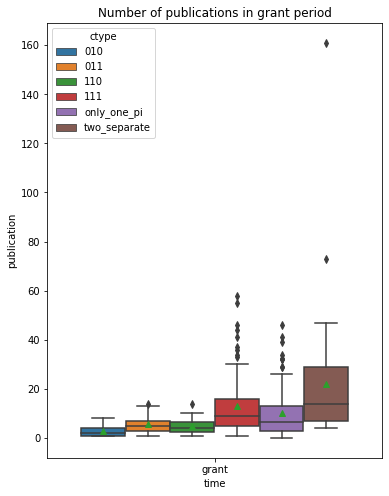

In [59]:
x = ["grant"]
ctype = ["010", "011", "110", "111", "only_one_pi", "two_separate"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_amount": [dict_amount[k] for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] if dict_publications[k][time] > 0 else 0 for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

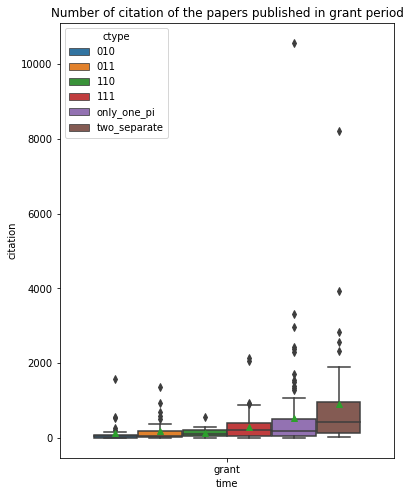

In [60]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

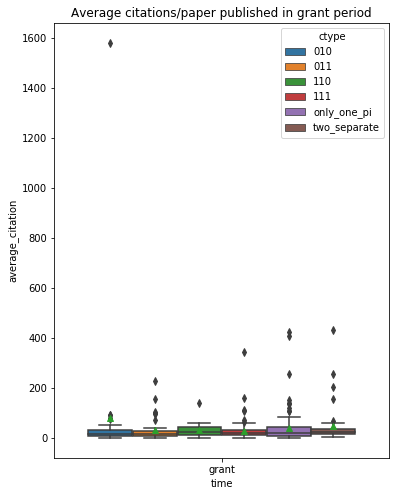

In [61]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

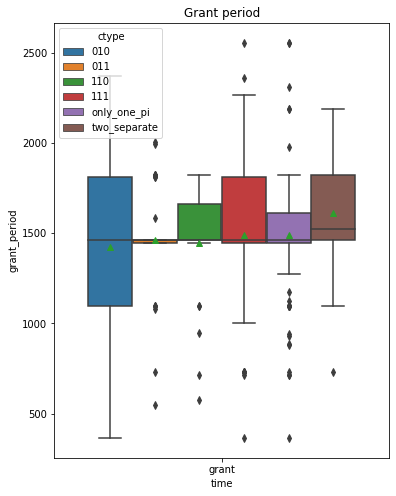

In [62]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

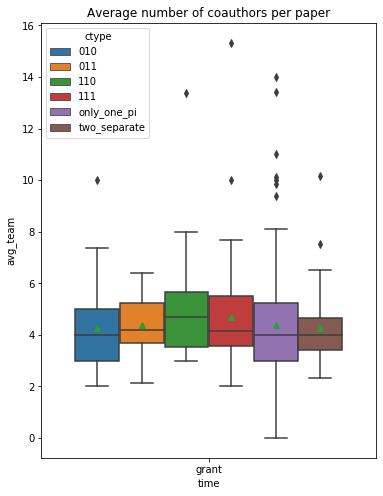

In [63]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")

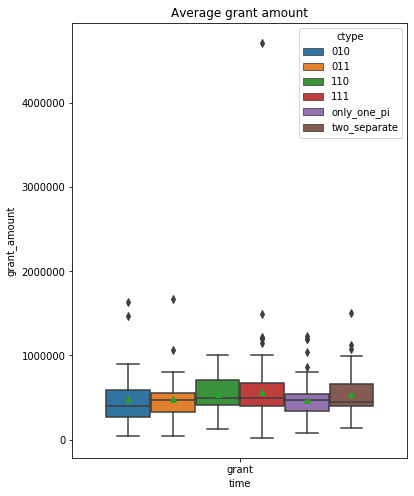

In [64]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_amount", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average grant amount")